# Topic Modeling of Tweets

In [1]:
import pandas as pd
import numpy as np
import pre_processing as pp
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim

In [2]:
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/jmrt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jmrt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Pre-processing: Cleaning and tokenization of tweets

In [8]:
tweets = pd.read_csv('data/tweets_Mar2021.csv')
print(tweets.shape)
tweets.head()

(17933, 6)


,Datetime,TweetId,Text,Username,MentionedUsers,ConversationId
0,2021-03-31 22:20:40+00:00,1377385383168765952,Activists protest renaming Chicago school afte...,FoxNews,[],1377385383168765952
1,2021-03-31 22:17:35+00:00,1377384607969013765,Border Patrol video shows smugglers abandoning...,FoxNews,[],1377384607969013765
2,2021-03-31 22:16:31+00:00,1377384339105669122,"Cause of Tiger Woods' car crash determined, bu...",FoxNews,[],1377384339105669122
3,2021-03-31 21:10:57+00:00,1377367836046192641,GOP rep urges HHS to halt reported plan to rel...,FoxNews,[],1377367836046192641
4,2021-03-31 20:33:27+00:00,1377358399759785987,"Some Democrats trying to stop Iowa, New Hampsh...",FoxNews,[],1377358399759785987


In [112]:
# remove words that start with @
tweets['Text'] = tweets['Text'].str.replace('(\@\w+.*?)',"")
# remove words that start with https
tweets['Text'] = tweets['Text'].str.replace(r"http\S+","")
# other cleaning stuff
tweets['cleaned_text'] = tweets['Text'].apply(pp.clean_text, stopwords=True,
                                              add_sw = ['u', 'said', 'says', 'icymi',
                                                       'th', 'n', 'seen', 'watch', 'may', 'year',
                                                       'would', 'say', 'de', 'get', 'could']
                                             )

tweets.cleaned_text[348]

'cuomo accuser lindsey boylan claims governor joked try mount dog'

### 1.1 Get the bi-grams and tokenize each article

In [113]:
pre_process_docs = pp.bi_gram(tweets.cleaned_text, min_count=15, threshold=50)
pre_process_docs = [pp.remove_stopwords(d, add_sw=['new', 'two', 'one', 'three']) for d in pre_process_docs]

In [114]:
pre_process_docs[348]

'cuomo accuser lindsey boylan claims governor joked try mount dog'

### 1.13 Tokenize

In [115]:
docs = [word_tokenize(doc) for doc in pre_process_docs] #Tokenize
print(docs[500])

['chicago', 'car', 'theft', 'happens', 'next', 'barstool', 'sports', 'founder', 'dave', 'portnoy', 'caught', 'video']


## 2. Topic Modeling with LDA

In [116]:
# Create a dictionary representation of the documents. 
dictionary = gensim.corpora.Dictionary(docs) 
print('Number of unique tokens: %d' % len(dictionary))

# Filter out words that occur more than 50% of the documents.
dictionary.filter_extremes(no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

#print('Number of unique tokens after filtering: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 18977
Number of documents: 17933


In [117]:
 #LdaMulticore uses all CPU cores to parallelize and speed up model training.
lda_model = gensim.models.LdaMulticore(corpus, num_topics = 15,
                                       id2word = dictionary, passes = 15,
                                       workers = 3, random_state=0)

In [178]:
topics = ['Border Crisis', 'International', 'Politics', 'Pandemic', 'Politics',
         'COVID', 'Finance', 'Economy', 'Other', 'BLM',
         'COVID', 'Other', 'Women Violence', 'UK', 'Business']
for idx, topic in lda_model.print_topics(-1):
    print('Topic {}: {} \nWords: {}'.format(idx+1, topics[idx],topic))
    print('')

Topic 1: Border Crisis 
Words: 0.011*"border" + 0.010*"biden" + 0.008*"trump" + 0.008*"crisis" + 0.008*"texas" + 0.006*"president" + 0.005*"donald_trump" + 0.005*"state" + 0.005*"ban" + 0.005*"sources"

Topic 2: International 
Words: 0.007*"japan" + 0.007*"music" + 0.006*"recovery" + 0.006*"fukushima" + 0.005*"services" + 0.005*"china" + 0.005*"nuclear" + 0.005*"african" + 0.005*"government" + 0.005*"first"

Topic 3: Politics 
Words: 0.026*"myanmar" + 0.016*"china" + 0.014*"biden" + 0.010*"plan" + 0.010*"exclusive" + 0.009*"covid" + 0.009*"military" + 0.009*"sources" + 0.008*"first" + 0.007*"bill"

Topic 4: Pandemic 
Words: 0.015*"uk" + 0.010*"india" + 0.009*"italy" + 0.008*"lockdown" + 0.008*"pm" + 0.008*"police" + 0.007*"johnson" + 0.006*"brazil" + 0.006*"look" + 0.006*"world"

Topic 5: Politics 
Words: 0.012*"biden" + 0.012*"senate" + 0.010*"cuomo" + 0.008*"new_york" + 0.006*"top" + 0.006*"president" + 0.005*"billion" + 0.005*"calls" + 0.005*"business" + 0.005*"china"

Topic 6: COVI

### 2.2 LDA Model Results: Topics Visualization

In [179]:
#For each documents, get the one topic which dominates the most

def dominant_per_document(ldamodel, corpus, texts):
    '''
    Get top topic per document
    '''
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                
                wp = ldamodel.show_topic(topic_num)
                
                topic_keywords = ", ".join([word for word, prop in wp])
                
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4),
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    
    sent_topics_df.columns = ['Dominant_Topic',
                              'Perc_Contribution',
                              'Topic_Keywords']
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    
    sent_topics_df['text'] = contents
    
    return sent_topics_df

In [180]:
dominant_topics = dominant_per_document(ldamodel=lda_model,
                                        corpus=corpus,
                                        texts=pre_process_docs)
dominant_topics['topic_name'] = dominant_topics['Dominant_Topic'].apply(lambda x: topics[int(x)])
dominant_topics

,Dominant_Topic,Perc_Contribution,Topic_Keywords,text,topic_name
0,8.0,0.5789,"first, election, union, writes, show, new_york...",activists protest renaming chicago school oppr...,Other
1,9.0,0.4809,"police, man, trial, george_floyd, people, char...",border patrol video shows smugglers abandoning...,BLM
2,8.0,0.5946,"first, election, union, writes, show, new_york...",cause tiger woods car crash determined truth n...,Other
3,10.0,0.6001,"biden, covid, pandemic, president, people, sta...",gop rep urges hhs halt reported plan release c...,COVID
4,2.0,0.4655,"myanmar, china, biden, plan, exclusive, covid,...",democrats trying stop iowa hampshire voting first,Politics
...,...,...,...,...,...
17928,5.0,0.5486,"covid, first, coronavirus, cases, vaccine, sue...",china cansino first vaccines packaged mexico r...,COVID
17929,4.0,0.8833,"biden, senate, cuomo, new_york, top, president...",australia home prices race fastest pace since ...,Politics
17930,7.0,0.3090,"first, last, billion, south, airlines, like, p...",ac milan edge roma thriller keep serie title r...,Economy
17931,4.0,0.6300,"biden, senate, cuomo, new_york, top, president...",new_york top prosecutor rejected proposal gove...,Politics


In [181]:
topic_weights = [dict(lda_model[x]) for x in corpus]
topic_weights = pd.DataFrame(topic_weights)
print("Topic Weights per Document")
topic_weights

Topic Weights per Document


,8,11,0,9,6,2,10,4,1,3,5,7,12,13,14
0,0.578859,0.297288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.422415,0.481276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.594605,NaN,NaN,NaN,0.318674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0.337927,0.600113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,0.465820,0.410345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.548603,0.327575,NaN,NaN,NaN
17929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.883318,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17930,NaN,NaN,NaN,NaN,NaN,0.297121,NaN,NaN,NaN,NaN,NaN,0.308897,NaN,NaN,0.293908
17931,NaN,NaN,0.197658,0.125182,NaN,NaN,NaN,0.630083,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
#Obtain the mean weight contribution of each topic and the count
stats = []
for col in topic_weights:
    d = {}
    d['mean_weight'] = topic_weights[col].mean()
    d['count'] = topic_weights[col].count()
    d['topic'] = col
    stats.append(d)

stats = pd.DataFrame(stats)
#Aggregate and merge all results
topic_counts = dominant_topics.groupby('Dominant_Topic').size().reset_index(name='dominant_count')

topic_counts = topic_counts.sort_values(by='dominant_count', ascending=False)
topic_counts = topic_counts.merge(stats, left_on='Dominant_Topic',
                                  right_on='topic').drop(columns='Dominant_Topic')

topic_counts.sort_values(by='topic', inplace=True)
topic_counts.reset_index(drop=True, inplace=True)

topic_counts['topic_name'] = topic_counts.apply(lambda x: topics[int(x['topic'])],
                                                axis=1)

wm = lambda x: np.average(x, weights=topic_counts.loc[x.index, "dominant_count"])

tc = topic_counts.groupby('topic_name').agg(mean_weight = ('mean_weight', wm)).reset_index()
tc2 = topic_counts.groupby('topic_name').agg(dominant_count = ('dominant_count', 'sum')).reset_index()

topic_counts = tc.merge(tc2)
topic_counts

,topic_name,mean_weight,dominant_count
0,BLM,0.252125,1263
1,Border Crisis,0.229027,1030
2,Business,0.234628,950
3,COVID,0.271411,2823
4,Economy,0.213436,849
5,Finance,0.257137,1235
6,International,0.238700,1033
7,Other,0.225557,1902
8,Pandemic,0.242986,1110
9,Politics,0.286425,3119


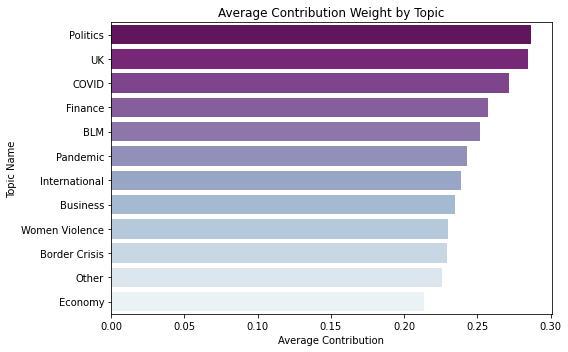

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
#topic_counts.sort_values(by='count', ascending=False, inplace=True)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))

sns.barplot(y="topic_name", x="mean_weight", 
            data=topic_counts.sort_values(by='mean_weight', 
                                          ascending=False),
            ax=ax1, palette='BuPu_r')
ax1.set_title('Average Contribution Weight by Topic', 
              fontdict=dict(size=12))
ax1.set_xlabel('Average Contribution')
ax1.set_ylabel('Topic Name')
fig.tight_layout();

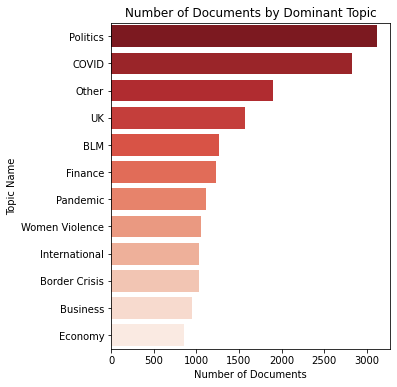

In [184]:
fig, ax1 = plt.subplots(figsize=(5, 6))
sns.barplot(y="topic_name", x="dominant_count",
data=topic_counts.sort_values(by='dominant_count',
                              ascending=False), 
            ax=ax1, palette='Reds_r')
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=12))
ax1.set_xlabel('Number of Documents')
ax1.set_ylabel('Topic Name');

In [185]:
tweets['Topic'] = dominant_topics['Dominant_Topic'].apply(lambda x: topics[int(x)])
#.to_csv('data/tweets.csv', index=False)
tweets[['TweetId','Username', 'ConversationId', 'Text', 'Topic']]

,TweetId,Username,ConversationId,Text,Topic
0,1377385383168765952,FoxNews,1377385383168765952,Activists protest renaming Chicago school afte...,Other
1,1377384607969013765,FoxNews,1377384607969013765,Border Patrol video shows smugglers abandoning...,BLM
2,1377384339105669122,FoxNews,1377384339105669122,"Cause of Tiger Woods' car crash determined, bu...",Other
3,1377367836046192641,FoxNews,1377367836046192641,GOP rep urges HHS to halt reported plan to rel...,COVID
4,1377358399759785987,FoxNews,1377358399759785987,"Some Democrats trying to stop Iowa, New Hampsh...",Politics
...,...,...,...,...,...
17928,1366180182965518337,Reuters,1366180182965518337,China's CanSino says first vaccines packaged i...,COVID
17929,1366178954260983809,Reuters,1366178954260983809,Australia home prices race at fastest pace sin...,Politics
17930,1366177667490406411,Reuters,1366177667490406411,AC Milan edge AS Roma in thriller to keep Seri...,Economy
17931,1366177614491189251,Reuters,1366177614491189251,New York's top prosecutor rejected a proposal ...,Politics


In [189]:
tweets[['TweetId','Username', 'ConversationId', 'Text', 'Topic']].to_csv('data/tweets.csv', index=False)

In [186]:
tweets[['Text', 'Topic']]

,Text,Topic
0,Activists protest renaming Chicago school afte...,Other
1,Border Patrol video shows smugglers abandoning...,BLM
2,"Cause of Tiger Woods' car crash determined, bu...",Other
3,GOP rep urges HHS to halt reported plan to rel...,COVID
4,"Some Democrats trying to stop Iowa, New Hampsh...",Politics
...,...,...
17928,China's CanSino says first vaccines packaged i...,COVID
17929,Australia home prices race at fastest pace sin...,Politics
17930,AC Milan edge AS Roma in thriller to keep Seri...,Economy
17931,New York's top prosecutor rejected a proposal ...,Politics


In [188]:
tweets[['Text', 'Topic']].iloc[17928].Text

"China's CanSino says first vaccines packaged in Mexico will be ready in March  "